### Note: All the trainings in this notebook take a very long time(about 10 min each with a GPU on Colab). Many of them could be run longer to get better results, but I kept training this long so that the notebook is less cumbersome

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils
import torchvision
import torchvision.models as models
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Part 1. Make a MNIST classifier using Pytorch and the Modified LeNet model

1a) Define the model. The model comes from HW7 and has 2 conv layers and 3 linear layers

In [ ]:
class modified_LeNet(nn.Module):
    def __init__(self):
        super(modified_LeNet, self).__init__()
        #Declare the model
        #From HW7, we have the model structure: two conv layers, two linear, and output
        self.conv1 = nn.Conv2d(1,6,5,1,2)
        self.conv2 = nn.Conv2d(6,16,5,1,0)
        self.lin1 = nn.Linear(400, 120, bias=True)
        self.lin2 = nn.Linear(120,84, bias=True)
        self.lin3 = nn.Linear(84,10,bias = True)
        self.pool = nn.MaxPool2d(2,2)


        
#Describe forward path through net. x is input data
    def forward(self, x):
        #Pass data through linear layers

        #Conv, relu, pool
        x = self.conv1(x)
        x = F.relu(x) 
        x = self.pool(x)

        #Conv, relu, pool
        x = self.conv2(x)
        x = F.relu(x) 
        x = self.pool(x)
        
        #Flatten but not in batch dimension
        x = torch.flatten(x, start_dim=1)
        
        #Linear 1 and relu
        x = self.lin1(x)
        x = F.relu(x) 
        
        #Linear 2 and relu
        x = self.lin2(x)
        x = F.relu(x)
        
        #Linear 3 and SM for output
        x = self.lin3(x)
        out = F.softmax(x, dim = 1)
        return out

#### Prepare the dataset and dataloaders. Make a dataloader for the full-data model and the small-data model

In [ ]:
#Import the data. Transform the data so that it is a tensor and we can work with it easier(instead of PIL)
mnist_dataset = datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

#Declare sizes for the sets. I chose a 70/30/0 split
train_len = int(len(mnist_dataset) * 0.7)
val_len = int(len(mnist_dataset) - train_len)

#Randomly split the dataset into the test, validation, and train sets
train_set, val_set = torch.utils.data.random_split(mnist_dataset, [train_len, val_len])


#Also create the dataloaders
#First, declare a batch size
batch_size = 10000
#Make a dataloader for each dataset
train_DL = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_DL = DataLoader(val_set, batch_size=batch_size, shuffle=True)


#For the small data problem, make a separate dataloader
#Take 200 random elements from the train_set
indicies = torch.randperm(len(train_set))[:200]
small_train_set = Subset(train_set, indicies)
small_train_DL = DataLoader(small_train_set, batch_size=100, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Test the dataloader to make sure it all matches up. The img should be a possible input and it should also have the correct label. Can rerun this code block to check new random data

Label is: 2


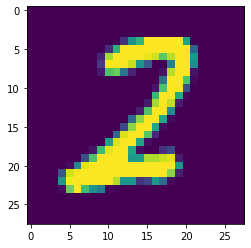

In [ ]:
img, label = [x[0] for x in iter(small_train_DL).next()]
plt.imshow(img.reshape(28,-1))
print("Label is: " + str(label.item()))

The dataloaders work as expected. We can define functions for training and evaluation of the model:

In [ ]:
"""
Function: Train a model
Inputs: model: model to train
        train_DL: Dataloader for trainset
        valid_DL: Dataloader for valid set
        num_epochs: number of training epochs
        lr: learning rate
        lambd: regularization of loss function
        
Outputs: model: trained model
         losses: list of trainset losses over iterations
         vallosses: list of valid set losses over iterations
"""
def trainLoop(model, train_DL, val_DL, num_epochs, lr, lambd, momentum = 0.9, verbose = True):
    #Declare the loss and optimizer
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum = momentum, weight_decay = lambd)
    
    #Create lists to store losses for plotting later
    losses = []
    valLosses = []
    valAccuracy = []
    
    #Iterate for each epoch
    for epoch in range(num_epochs):
        
        #Make values to store loss and count samples
        total_loss = 0
        trainSamples = 0
        #Loop through the train loader
        for step, (data, labels) in enumerate(train_DL):
            #Send the data and labels to GPU
            inputs= data.to(device).float()
            labels = labels.to(device).long()
            #Zero gradients
            optimizer.zero_grad()
            #Find predictions and calculate loss on GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            #Use Autograd to find gradients
            loss.backward()
            #Step with the gradients
            optimizer.step()
            #Store loss and count samples
            total_loss += loss.item()
            trainSamples += 1

        #Find the validation loss
        #Make variables to store the loss and samples
        total_val_loss = 0  
        validSamples = 0
        #Set to eval mode for validation set and iterate through the valid dataloader
        model.eval()
        for step, (data, labels) in enumerate(val_DL):
            #Pass validation data to GPU
            inputs = data.to(device).float()
            labels = labels.to(device).long()
            #Forward pass to find loss. Use eval mode for valid set
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss +=loss.item()
            validSamples += 1
        
        #Use eval function to find validation accuracy
        valAccuracy.append(evaluateModel(model, val_DL, verbose = False)[0])
        #return to train mode after finding validation accuracy and
        model.train()
        
        #Print out accuracies if wanted
        if epoch%1 ==0 and epoch !=0 and verbose ==True:
            print("Epoch: " + str(epoch)+ ". Average loss per training sample is: "+str(total_loss/trainSamples))
            print("Epoch: " + str(epoch)+ ". Average loss per valid sample is: "+str(total_val_loss/validSamples) + '\n')


        #Save losses per sample
        losses.append(total_loss/trainSamples)
        valLosses.append(total_val_loss/validSamples)
        
    return model, losses, valLosses, valAccuracy

In [ ]:
"""
Function: Evaluate a trained model
Inputs: model: model to evaluate
        test_DL: Dataloader to use for evaluation

        
Outputs: Accuracy: Accuracy of the model on the given DL
"""
def evaluateModel(model, test_DL, verbose = True):
    #Put the model in eval mode
    model.eval()
    #Save numbers for the correct guesses, total, and incorrect
    correct = 0
    total = 0
    incorrect = 0
    #Also save misclassified samples for debugging net
    badPreds = []
    
    #Don't save gradients
    with torch.no_grad():
        #Iterate through the DL
        for data in test_DL:
            #Find the predictions on the data
            inputs, labels = data
            outputs = model(inputs.to(device).float())
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu().numpy()
            labels = labels.numpy()
            #Iterate through labels
            for x in range(len(labels)):
                total +=1
                #If label doesn't match predictions, increment incorrect and save the sample for debugging
                if labels[x]!=predicted[x]:
                    incorrect +=1
                    badPreds.append([inputs[x], outputs.data[x], labels[x], predicted[x]])
                #Otherwise it's correct
                else:
                    correct +=1
    #Print out the accuracy if wanted
    if verbose:
        print('Accuracy of the network on the ' + str(total) + ' test images: %d %%' % (
            100 * correct / total))
    
    #Calculate accuracy and return it alongside mispredicted samples
    accuracy = correct / total
    return accuracy, badPreds

Also define a helper function for plotting results from the training

In [ ]:
"""
Function: Plot losses of a trained model
Inputs: val_loss: list of validation losses
        train_loss: list of test set losses

        
Outputs: N/a
"""
def plotLosses(val_loss, train_loss, valid_accuracy = False):
    #Setup subplots
    ax2 = plt.subplot(2,1,2)
    #Label plots
    ax2.plot(val_loss, label = 'Validation loss')
    ax2.plot(train_loss, label = 'Train loss')
    if valid_accuracy != False:
      ax1 = plt.subplot(2,1,1)
      ax1.plot(valid_accuracy, label = 'Validation Accuracy')
      ax1.set_xlabel("Iteration")
      ax1.set_ylabel("Validation Accuracy")
      ax1.legend()
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Loss per Sample")
    ax2.legend()
    plt.show()

1b) Run training with the full data problem. I found that some training attempts went quickly while others took a long while. This is currently set for 50 epochs, which takes a long time to run

In [ ]:
#Train on the full dataset
#Declare parameters for nn and training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 50
lr = 0.1
lambd = 0.00001

#Make the model
model = modified_LeNet().to(device).train()
#Train the model
trained_model, losses, valid_losses, valid_accuracy = trainLoop(model, train_DL, val_DL, num_epochs, lr, lambd, momentum=0.9)

	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 lin1.weight
	 lin1.bias
	 lin2.weight
	 lin2.bias
	 lin3.weight
	 lin3.bias


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1. Average loss per training sample is: 2.302078437805176
Epoch: 1. Average loss per valid sample is: 2.3017174005508423

Epoch: 2. Average loss per training sample is: 2.301276969909668
Epoch: 2. Average loss per valid sample is: 2.3008086681365967

Epoch: 3. Average loss per training sample is: 2.3002281188964844
Epoch: 3. Average loss per valid sample is: 2.2995963096618652

Epoch: 4. Average loss per training sample is: 2.298822546005249
Epoch: 4. Average loss per valid sample is: 2.2978073358535767

Epoch: 5. Average loss per training sample is: 2.2966681480407716
Epoch: 5. Average loss per valid sample is: 2.2948068380355835

Epoch: 6. Average loss per training sample is: 2.29257755279541
Epoch: 6. Average loss per valid sample is: 2.2886253595352173

Epoch: 7. Average loss per training sample is: 2.282982349395752
Epoch: 7. Average loss per valid sample is: 2.270003914833069

Epoch: 8. Average loss per training sample is: 2.2425222873687742
Epoch: 8. Average loss per vali

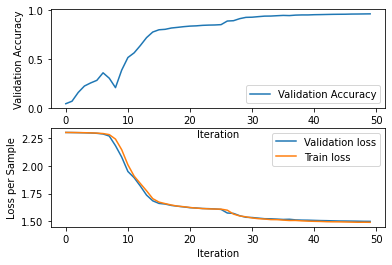

Max accuracy0.9645


In [ ]:
#Plot the results
plotLosses(valid_losses, losses, valid_accuracy)
print("Max accuracy" + str(max(valid_accuracy)))

1c)Run training with the partial data problem(Also takes a while)

In [ ]:
#Train on a small subset
#Declare parameters for nn and training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 50
lr = 0.1
lambd = 0.00001

#Make the model
model = modified_LeNet().to(device).train()
#Train the model. The small dataloader is already defined
trained_model, losses, valid_losses, valid_accuracy = trainLoop(model, small_train_DL, val_DL, num_epochs, lr, lambd, momentum=0.9)

	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 lin1.weight
	 lin1.bias
	 lin2.weight
	 lin2.bias
	 lin3.weight
	 lin3.bias
Epoch: 1. Average loss per training sample is: 2.3026342391967773
Epoch: 1. Average loss per valid sample is: 2.3026541471481323

Epoch: 2. Average loss per training sample is: 2.3025327920913696
Epoch: 2. Average loss per valid sample is: 2.3026317358016968

Epoch: 3. Average loss per training sample is: 2.302402973175049
Epoch: 3. Average loss per valid sample is: 2.3025962114334106

Epoch: 4. Average loss per training sample is: 2.302234172821045
Epoch: 4. Average loss per valid sample is: 2.302554726600647

Epoch: 5. Average loss per training sample is: 2.302063226699829
Epoch: 5. Average loss per valid sample is: 2.3025203943252563

Epoch: 6. Average loss per training sample is: 2.301864504814148
Epoch: 6. Average loss per valid sample is: 2.3024771213531494

Epoch: 7. Average loss per training sample is: 2.301637291908264
Epoch: 7. Average loss per

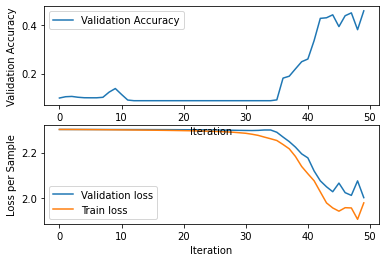

Max accuracy0.45816666666666667


In [ ]:
#Plot the results
plotLosses(valid_losses, losses, valid_accuracy)
print("Max accuracy" + str(max(valid_accuracy)))

## Comparison of full-data and small-data problems:
The full data problem trains much more robustly. Training with a small dataset often gets stuck in local minimums or oscillates between getting worse and better. Over many training runs, it often took a while to converge and didn't achieve as good of accuracy as the full data problem. This is because the small dataset lacks the variation needed to generalize to the validation set. Looking at the outputs from the training, there is a larger spread between training loss and validation loss for the small dataset at each iteration; the results of training are not generalizing to the validation set as well.

## Part 2. Convolutional Autoencoder

Part 2a) Define the autoencoder model. 

In [ ]:
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        #Declare the model
        #From HW7, we have the model structure: two conv layers as the encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1,6,5,1,2),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(6,16,5,1,0),
            nn.MaxPool2d(2,2),
            nn.ReLU()
        )
        #Make decoder layers to return to original dims
        self.decoder = nn.Sequential(
            nn.Conv2d(16,6,3,1,2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(6,1,3,1,1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2)
        )

        
#Describe forward path through net. x is input data
    def forward(self, x):
        #Pass data through linear layers

        x = self.encoder(x)
        out = self.decoder(x)

        return out

The dataset used for training the autoencoder is different than the classification. Here, I'll make a dataset where the input images have a copy of the image as their label:

In [ ]:
class mnistAutoencoder(torch.utils.data.Dataset):
  '''
  Custom Dataset class for mnist autoencoder training
  '''
  
  def __init__(self, inputData):
    a_class = []
    #make a list of images as the datastructure
    for i,label in inputData:
        a_class.append(i)
    self.imgs= a_class
    
  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, index):
    #When an image is retrieved, return a copy of it as the label as well
    img = self.imgs[index]
    img_original = np.asarray(img)

    return torch.from_numpy(img_original).float(), torch.from_numpy(img_original).float()

Initialize a dataset for autoencoder training. Also setup dataloaders for the dataset

In [ ]:
autoencoder_set = mnistAutoencoder(mnist_dataset)
#Declare sizes for the sets. I chose a 60/20/20 split
train_len = int(len(autoencoder_set) * 0.6)
test_len = int(len(autoencoder_set) * 0.2)
validation_len = len(autoencoder_set)-(train_len+test_len)
#Randomly split the dataset into the test, validation, and train sets
train_set, val_set, test_set = torch.utils.data.random_split(autoencoder_set, [train_len, validation_len, test_len])


#Also create the dataloaders
#First, declare a batch size
batch_size = 10000
#Make a dataloader for each dataset
a_train_DL = DataLoader(train_set, batch_size=batch_size, shuffle=True)
a_val_DL = DataLoader(test_set, batch_size=batch_size, shuffle=True)
a_test_DL = DataLoader(val_set, batch_size=batch_size, shuffle=True)


Check that everything works as expected

Our labels are now just our original images as desired


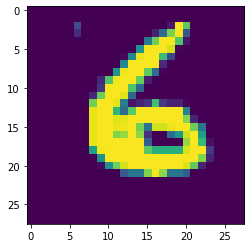

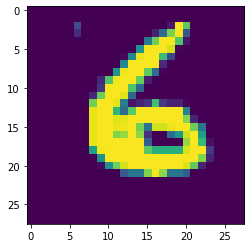

In [ ]:
img, label = [x[0] for x in iter(a_train_DL).next()]
plt.imshow(label.reshape(28,-1))
plt.figure()
plt.imshow(img.reshape(28,-1))
print("Our labels are now just our original images as desired")

I defined another train loop for the autoencoders. This really wasn't that necessary(and the code looks a lot like the first train loop). But this one saves the model(since we use it for transfer learning), can use a loss function other than classification loss, and it doesn't call evaluateModel to record accuracies for runtime considerations(and since accuracy doesn't make as much sense outside of the classification context)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    train_since = time.time()
    
    losses = []
    valLosses = []
    minimal_loss = 1e10
    size = dict()
    for i in dataloaders:
      size[i] = len(dataloaders[i].dataset)
    for epoch in range(num_epochs):
        since = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                if phase == 'train':
                    optimizer.zero_grad()  # zero the parameter gradients
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / size[phase]         
            print('{} Loss: {:.6f} Time: {:.4f}s'.format(phase, epoch_loss, time.time()-since))
            if phase == 'train':
              losses.append(epoch_loss)   
            if phase == 'val':
                valLosses.append(epoch_loss)
                if epoch > 3 and minimal_loss > epoch_loss:
                    minimal_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

    model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - train_since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Minimal Loss: {:6f}'.format(minimal_loss))
    model.load_state_dict(best_model_wts)
    

    return model, model_wts, best_model_wts, losses, valLosses

2b) Run the train loop with the conv_autoencoder model

In [ ]:
a_model = conv_autoencoder()
criterion = nn.MSELoss()
num_epochs = 25
optimizer = torch.optim.Adam(a_model.parameters(), lr=9e-4, weight_decay=0.0001)
# Move model and loss function to GPU
if torch.cuda.is_available(): 
  criterion = criterion.cuda()
  a_model = a_model.cuda()
loader_set = dict()
loader_set['train'] = a_train_DL
loader_set['val'] = a_val_DL

a_model, model_wts, best_model_wts, losses, valLosses = train_model(a_model,loader_set, criterion, optimizer, num_epochs)

Epoch 0/24
----------
train Loss: 0.868487 Time: 1.7296s
val Loss: 0.867315 Time: 2.0307s
Epoch 1/24
----------
train Loss: 0.683676 Time: 1.4930s
val Loss: 0.812776 Time: 1.7986s
Epoch 2/24
----------
train Loss: 0.618207 Time: 1.4770s
val Loss: 0.762666 Time: 1.7747s
Epoch 3/24
----------
train Loss: 0.571870 Time: 1.4774s
val Loss: 0.704258 Time: 1.7107s
Epoch 4/24
----------
train Loss: 0.540082 Time: 1.5724s
val Loss: 0.631291 Time: 1.8122s
Epoch 5/24
----------
train Loss: 0.519374 Time: 1.5958s
val Loss: 0.552537 Time: 1.8436s
Epoch 6/24
----------
train Loss: 0.501696 Time: 1.5606s
val Loss: 0.500442 Time: 1.8010s
Epoch 7/24
----------
train Loss: 0.487631 Time: 1.5475s
val Loss: 0.480200 Time: 1.7895s
Epoch 8/24
----------
train Loss: 0.476248 Time: 1.5803s
val Loss: 0.468963 Time: 1.8231s
Epoch 9/24
----------
train Loss: 0.466342 Time: 1.4824s
val Loss: 0.459774 Time: 1.7772s
Epoch 10/24
----------
train Loss: 0.457798 Time: 1.4921s
val Loss: 0.449536 Time: 1.7899s
Epoch 11/

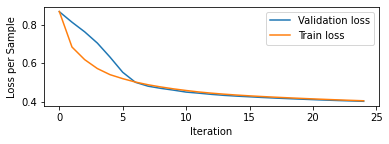

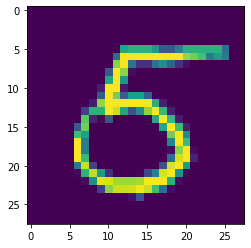

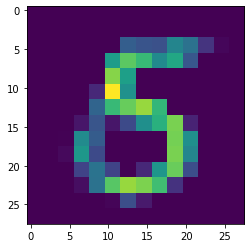

In [ ]:
plotLosses(valLosses, losses)
plt.figure()
img, label = [x[0] for x in iter(a_train_DL).next()]
img = img.reshape(1,1,28,28).cuda()
plt.imshow(label.reshape(28,28))
plt.figure()
output = a_model(img)
output = output.detach().cpu().numpy()
plt.imshow(output.reshape(28,28))

2c) Define and train a second model that has one more conv layer in the encoder and the decoder

In [ ]:
class conv_autoencoder_deep(nn.Module):
    def __init__(self):
        super(conv_autoencoder_deep, self).__init__()
        #Declare the model
        #The new model has three conv layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1,12,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(12,24,5,1,0),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(24,30,3,1,1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(30,24,3,1,2),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(24,12,3,1,1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(12,1,3,1,1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
        )
    def forward(self, x):
        #Pass data through linear layers

        x = self.encoder(x)
        out = self.decoder(x)
        
        return out


In [ ]:
de_model = conv_autoencoder_deep()
criterion = nn.MSELoss()
num_epochs = 25
optimizer = torch.optim.Adam(de_model.parameters(), lr=9e-4, weight_decay=0.0001)
# Move model and loss function to GPU
if torch.cuda.is_available(): 
  criterion = criterion.cuda()
  de_model = de_model.cuda()
loader_set = dict()
loader_set['train'] = a_train_DL
loader_set['val'] = a_val_DL

de_model, model_wts, best_model_wts,  losses, valLosses = train_model(de_model,loader_set, criterion, optimizer, num_epochs)

Epoch 0/24
----------
train Loss: 1.142370 Time: 2.9926s
val Loss: 0.996768 Time: 3.3879s
Epoch 1/24
----------
train Loss: 0.673572 Time: 2.9665s
val Loss: 0.992835 Time: 3.3800s
Epoch 2/24
----------
train Loss: 0.575445 Time: 2.9542s
val Loss: 0.990595 Time: 3.3770s
Epoch 3/24
----------
train Loss: 0.511957 Time: 2.9671s
val Loss: 0.949500 Time: 3.3648s
Epoch 4/24
----------
train Loss: 0.467909 Time: 2.9545s
val Loss: 0.873026 Time: 3.3488s
Epoch 5/24
----------
train Loss: 0.437454 Time: 2.8759s
val Loss: 0.785698 Time: 3.3500s
Epoch 6/24
----------
train Loss: 0.413446 Time: 2.9170s
val Loss: 0.659177 Time: 3.3939s
Epoch 7/24
----------
train Loss: 0.394734 Time: 2.9167s
val Loss: 0.570619 Time: 3.3943s
Epoch 8/24
----------
train Loss: 0.378299 Time: 2.9118s
val Loss: 0.498310 Time: 3.3956s
Epoch 9/24
----------
train Loss: 0.364316 Time: 2.8712s
val Loss: 0.424965 Time: 3.3479s
Epoch 10/24
----------
train Loss: 0.352267 Time: 2.9116s
val Loss: 0.380307 Time: 3.3860s
Epoch 11/

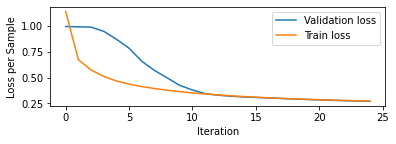

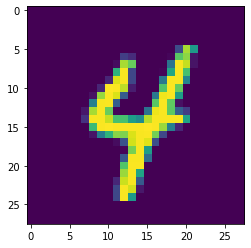

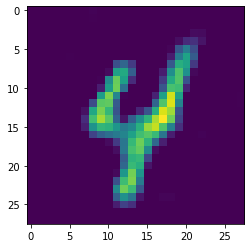

In [ ]:
plotLosses(valLosses, losses)
plt.figure()

img, label = [x[0] for x in iter(a_train_DL).next()]
img = img.reshape(1,1,28,28).cuda()
plt.imshow(label.reshape(28,28))
plt.figure()
output = de_model(img)
output = output.detach().cpu().numpy()
plt.imshow(output.reshape(28,28))

The deeper model does slightly better in the autoencoder task!

## Part 3: Transfer Learning

1a) Make a model to use the autoencoder as a backbone

First, make a helper function to freeze weights of the backbone

In [ ]:
def remove_grad(model):
  for param in model.parameters():
    param.requires_grad = False
  return model

Define the model. Take the encoder from the autoencoder, freeze it, and feed to linear for output.

In [ ]:
class transfer_classifier(nn.Module):
  def __init__(self, model, num_feats):
    super(transfer_classifier, self).__init__()

    ## First half: encoder
    self.encoder = remove_grad(model.encoder)

    ## Second half: classify
    #Flatten but not in batch dimension
    self.lin = nn.Linear(num_feats, 10, bias = True)

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    encoder_features = self.encoder(input)

    # Upsample to get colors
    x = torch.flatten(encoder_features, start_dim=1)
    x = self.lin(x)
    out = F.softmax(x, dim = 1)
    return out

3b) Train the autoencoder backbone model on the small train dataloader

In [ ]:
#Transfer learn on MNIST
#Declare parameters for nn and training
num_epochs = 75
lr = 0.1
lambd = 0.00001

#Make the model
a_t_model = transfer_classifier(a_model, 400).to(device).train()
#Train the model
trained_model, losses, valid_losses, valid_accuracy = trainLoop(a_t_model, small_train_DL, val_DL, num_epochs, lr, lambd)

	 lin.weight
	 lin.bias
Epoch: 1. Average loss per training sample is: 2.288128972053528
Epoch: 1. Average loss per valid sample is: 2.2867645025253296

Epoch: 2. Average loss per training sample is: 2.269884705543518
Epoch: 2. Average loss per valid sample is: 2.2761164903640747

Epoch: 3. Average loss per training sample is: 2.244597911834717
Epoch: 3. Average loss per valid sample is: 2.2620891332626343

Epoch: 4. Average loss per training sample is: 2.213038682937622
Epoch: 4. Average loss per valid sample is: 2.2414774894714355

Epoch: 5. Average loss per training sample is: 2.175537586212158
Epoch: 5. Average loss per valid sample is: 2.2104501724243164

Epoch: 6. Average loss per training sample is: 2.137901782989502
Epoch: 6. Average loss per valid sample is: 2.1887346506118774

Epoch: 7. Average loss per training sample is: 2.108630418777466
Epoch: 7. Average loss per valid sample is: 2.173689603805542

Epoch: 8. Average loss per training sample is: 2.084684371948242
Epoch: 8.

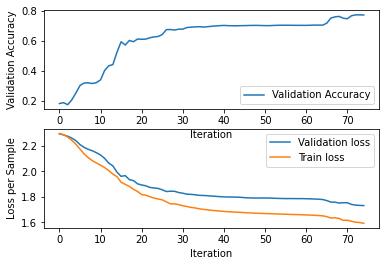

Max accuracy0.7745


In [ ]:
#Plot the results
plotLosses(valid_losses, losses, valid_accuracy)
print("Max accuracy" + str(max(valid_accuracy)))

3c) Train a version of the model using the deep autoencoder's encoder as the backbone

In [ ]:
#Transfer learn on MNIST
#Declare parameters for nn and training
num_epochs = 75
lr = 0.1
lambd = 0.00001

#Make the model
d_t_model = transfer_classifier(de_model, 750).to(device).train()
#Train the model
trained_model, losses, valid_losses, valid_accuracy = trainLoop(d_t_model, small_train_DL, val_DL, num_epochs, lr, lambd)

	 lin.weight
	 lin.bias
Epoch: 1. Average loss per training sample is: 2.298816204071045
Epoch: 1. Average loss per valid sample is: 2.2957305908203125

Epoch: 2. Average loss per training sample is: 2.2900487184524536
Epoch: 2. Average loss per valid sample is: 2.2909857034683228

Epoch: 3. Average loss per training sample is: 2.2786444425582886
Epoch: 3. Average loss per valid sample is: 2.2862753868103027

Epoch: 4. Average loss per training sample is: 2.263936996459961
Epoch: 4. Average loss per valid sample is: 2.282291889190674

Epoch: 5. Average loss per training sample is: 2.2476788759231567
Epoch: 5. Average loss per valid sample is: 2.2733967304229736

Epoch: 6. Average loss per training sample is: 2.2266868352890015
Epoch: 6. Average loss per valid sample is: 2.2557677030563354

Epoch: 7. Average loss per training sample is: 2.206380009651184
Epoch: 7. Average loss per valid sample is: 2.236521601676941

Epoch: 8. Average loss per training sample is: 2.1786683797836304
Epoch

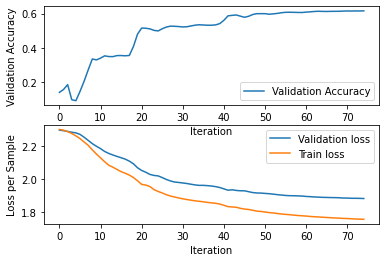

Max accuracy0.6163888888888889


In [ ]:
#Plot the results
plotLosses(valid_losses, losses, valid_accuracy)
print("Max accuracy" + str(max(valid_accuracy)))

Both 3b and 3c use transfer learning to train better on the small dataset. Looking at the training and validation losses during training, 3b and 3c begin improving loss and accuracy much earlier in training. This is the case because they were able to learn features of the larger dataset in the autoencoder training, and the new training is just applying those features to a classification problem. Additionally, training with transfer learning had a smoother progression. Loss seems less likely to backtrack, possibly because there are less complex gradients with the one linear layer.

Interestingly, 3b performs significantly better than 3c in the classification problem, despite 3c using the deeper autoencoder that did better on the autoencoder task. This is likely the case because deep autoencoder produces more features so it could be more difficult to train with limited data(model complexity requires more data). It could also possibly be the case because the features generated by the deep autoencoder are more specific to the autoencoder task.

Overall, transfer learning made training faster and smoother.